In [16]:
import torch
from torch_geometric.data import Data
from torch.nn import Sequential, Linear, ReLU, Tanh
from torch_geometric.nn import NNConv
from torch_geometric.loader import DataLoader
import numpy as np


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# Example graph with 4 edges
# edge_index = torch.tensor([[0, 1, 2, 3], [1, 2, 3, 4]], dtype=torch.long)

# # Edge features (distance, conductivity, etc.)
# edge_features = torch.tensor([[0.1, 1.5], [0.2, 1.0], [0.3, 0.8], [0.4, 1.2]], dtype=torch.float)

# # Node features (3 features per node)
# node_features = torch.rand(5, 3)

# graph_data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_features)

cuda


In [1]:
# !pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.7 MB/s eta 0:00:00


**Running on Colab**
*   Need to pip install torch_geometric
*   Correct the filename as needed.




In [17]:
import h5py

filename = "./sample_data/Initial_test2.h5"
# T_output = []
# edge_distances = []
# edge_mappings = []
# one_hot_features = []
graphs = []
# scale_T = 5000

with h5py.File(filename, "r") as f:
    h5_graphs = list(f.keys())
    # for key in f.keys():
    for i in range(len(h5_graphs)):
        print(h5_graphs[i])
        graph = h5_graphs[i]

        T_output = f[graph]["Temperature"][()]
        edge_distances = (f[graph]["edge_distance"][()])
        edge_mappings = f[graph]["edge_mappings"][()] - 1 #adjusting for Python Indexing
        one_hot_features = f[graph]["one_hot_features"][()]

        T_output = np.log1p(T_output)
        print(np.max(T_output))
        print(T_output.shape)
        # print(edge_distances.shape)
        # print(edge_mappings.shape)
        # print(one_hot_features.shape)

        #

        edge_mappings = edge_mappings.astype(np.int64)

        graphs.append(Data(
        x= torch.from_numpy(one_hot_features.reshape(-1,3)).float(),
        edge_index=torch.from_numpy(edge_mappings.reshape(2,-1)),
        edge_attr=torch.from_numpy(edge_distances.reshape(-1,1)).float(),  # 1 feature distance
        y=torch.from_numpy(T_output.reshape(-1,1)).float()  # Target output for each node
        ))

loader = DataLoader(graphs, batch_size=2, shuffle=True)

graph_1
1.534118694545857
(1, 360)
graph_10
0.3831775200970455
(1, 95)
graph_2
0.8260139907191517
(1, 224)
graph_3
0.9608185904891002
(1, 224)
graph_4
1.6607249212473791
(1, 122)
graph_5
1.206044015343921
(1, 291)
graph_6
0.16038780340489261
(1, 122)
graph_7
0.3831741633234894
(1, 95)
graph_8
0.7350542591993495
(1, 176)
graph_9
0.9602539448393923
(1, 137)


In [24]:
class EdgeFeatureGNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, edge_feature_dim, output_dim):
        super().__init__()

        # Output size of edge_nn must match (hidden_dim * input_dim)
        edge_nn_1 = Sequential(
            Linear(edge_feature_dim, hidden_dim * input_dim),
            # Linear(edge_feature_dim, edge_feature_dim),
            ReLU()
        )

        edge_nn_2 = Sequential(
            Linear(edge_feature_dim, hidden_dim * hidden_dim),
            # Linear(edge_feature_dim, edge_feature_dim),
            ReLU()
        )

        self.conv1 = NNConv(input_dim, hidden_dim, edge_nn_1, aggr='mean')
        self.conv2 = NNConv(hidden_dim, hidden_dim, edge_nn_2, aggr='mean')

        self.fc = Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        # print(x.shape)
        x = self.conv1(x, edge_index, edge_attr).tanh()
        # print(x.shape)
        x = self.conv2(x, edge_index, edge_attr).tanh()
        return self.fc(x)

# Dummy graph data setup
# node_features = torch.rand(6, 3)  # 6 nodes with 3 features
# edge_index = torch.tensor([[0, 1, 2, 3, 4], [1, 2, 3, 4, 5]], dtype=torch.long)
# edge_features = torch.rand(5, 2)  # 5 edges with 2 features

# graph_data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_features)

# model = EdgeFeatureGNN(input_dim=3, hidden_dim=8, edge_feature_dim=2, output_dim=1)
# output = model(graph_data)
# print("Node-level predictions shape:", output.shape)

In [25]:
model = EdgeFeatureGNN(input_dim=3, hidden_dim=16,
                       edge_feature_dim=1, output_dim=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.008)
loss_fn = torch.nn.MSELoss()

# Training loop
epochs = 15000
for epoch in range(epochs):
    total_loss = 0
    for batch in loader:
        optimizer.zero_grad()

        # Forward pass
        out = model(batch.to(device))
        loss = loss_fn(out, batch.y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    if((epoch+1)%200==0):
      print(f"Epoch {epoch + 1}, Loss: {total_loss:.4f}")

Epoch 200, Loss: 0.4301
Epoch 400, Loss: 0.3693
Epoch 600, Loss: 0.4324
Epoch 800, Loss: 0.4274
Epoch 1000, Loss: 0.4736
Epoch 1200, Loss: 0.3856
Epoch 1400, Loss: 0.3837
Epoch 1600, Loss: 0.4526
Epoch 1800, Loss: 0.4289
Epoch 2000, Loss: 0.4062
Epoch 2200, Loss: 0.4189
Epoch 2400, Loss: 0.4063
Epoch 2600, Loss: 0.4332
Epoch 2800, Loss: 0.4079
Epoch 3000, Loss: 0.4511
Epoch 3200, Loss: 0.4528
Epoch 3400, Loss: 0.4052
Epoch 3600, Loss: 0.4328
Epoch 3800, Loss: 0.3773
Epoch 4000, Loss: 0.4277
Epoch 4200, Loss: 0.3833
Epoch 4400, Loss: 0.3877
Epoch 4600, Loss: 0.4674
Epoch 4800, Loss: 0.4550
Epoch 5000, Loss: 0.3984
Epoch 5200, Loss: 0.4570
Epoch 5400, Loss: 0.4453
Epoch 5600, Loss: 0.4462
Epoch 5800, Loss: 0.3859
Epoch 6000, Loss: 0.3706
Epoch 6200, Loss: 0.3945
Epoch 6400, Loss: 0.4144
Epoch 6600, Loss: 0.3962
Epoch 6800, Loss: 0.3961
Epoch 7000, Loss: 0.4135
Epoch 7200, Loss: 0.3744
Epoch 7400, Loss: 0.4252
Epoch 7600, Loss: 0.3982
Epoch 7800, Loss: 0.4004
Epoch 8000, Loss: 0.3804
Epoc

(122, 1)
(176, 1)
(224, 1)
(291, 1)
(95, 1)
(360, 1)
(224, 1)
(122, 1)
(95, 1)
(137, 1)


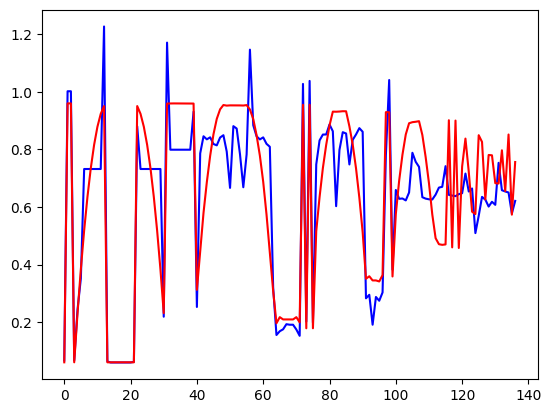

In [26]:
import matplotlib.pyplot as plt

test_loader = DataLoader(graphs, batch_size=1, shuffle=True)


for batch in test_loader:
        # Forward pass
    out_T = model(batch.to(device)).cpu().detach().numpy()
    print(out_T.shape)

plt.plot(out_T,'b')
plt.plot(T_output.reshape(-1,1),'r')